# Vegetation Change Detection

*Notebook currently compatible with the `DE Africa` Sandbox

### Background
Detecting regions of deforestation and afforestation in satellite imagery is complicated by the need to distinguish real land use changes from the natural variability introduced by climate variability.  To determine regions that have undergone significant change, we can apply hypotheisis testing techniques to stacks of remotely sensed satellite images to determine where change is statistically significant relative to the natural, background variability.


### Description
In this example, we measure the presence of vegetation from USGS Landsat Collection 2 imagery and apply a hypothesis test to identify areas of significant change (along with the direction of the change).  Here we use the [Fractional Cover (FC)](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) dataset. FC represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynthetic vegetation (NPV).  The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program [(JRSRP)](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover), which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

The worked example takes users through the code required to do the following:
1. Load cloud-free Fractional Cover images (derived from Landsat 8) for an area of interest (AOI).
2. Apply a statistical hypothesis test to find areas of significant change.
3. Visualise the statistically significant areas.

### Technical details
* **Products used:** Landsat Collection 2, Fractional Cover
* **Analyses used:** image differencing, hypothesis testing

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and any supporting functions for the analysis.

In [3]:
import datacube
import datacube.utils.rio
#from datacube.utils.dask import start_local_dask
#from datacube.utils.rio import configure_s3_access
from datacube.helpers import write_geotiff
from datacube.storage.masking import make_mask
from datacube.utils.geometry import CRS
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
import xarray as xr
import dask
import os

import sys
sys.path.append('/home/jovyan/odc-hub/')
from deaAfricascripts.deafrica_datahandling import mostcommon_crs
from deaAfricascripts.deafrica_plotting import display_map

#This will speed up loading data
#datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell.

In [4]:
#dask.config.set({"distributed.dashboard.link": 
 #       os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"})

#client = start_local_dask(n_workers=2, threads_per_worker=2, memory_limit='7G')
#display(client)

#creds = configure_s3_access(client=client, 
 #                           region_name='auto')
import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [5]:
dc = datacube.Datacube(app="Change_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
There is also a parameter to define how the data is split in time; the split yields two non-overlapping samples, which is a requirement of the hypothesis test we want to run (more detail below).
The parameters are:

* `latitude`: The latitude at the centre of your AOI (e.g. `-35.271`).
* `longitude`: The longitude at the centre of your AOI (e.g. `19.620`).
* `buffer`: The size, in decimal degrees, of the box to draw around your lat, lon point, this will determine the size of your AOI. 
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
For reasonable results, the range should span at least two years to prevent detecting seasonal changes.
* `time_baseline`: The date at which to split the total sample into two non-overlapping samples (e.g. `'2017-12-01'`).
For reasonable results, pick a date that is about halfway between the start and end dates specified in `time`.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers a location in the Western Cape, South Africa, where a fire removed some forest cover. 


In [34]:
# Define the area of interest
latitude = -18.00
longitude = 177.481
buffer = 0.045

# Set the range of dates for the complete sample
time = ('2016-01-01', '2017-12-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2016-10'


## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [35]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

## Load and view Fractional Cover (FC) data

The first step in the analysis is to load fractional cover data for the specified area of interest and time range. Fractional cover data includes three bands, the `Photosynthetic Vegetation (PV)` fraction, the `Non-Photosynthtic Vegetation (NPV)` fraction, and the `Bare Soil (BS)` fraction.  For this analysis, we are only intersted in the PV fraction, as this is the band we'll use to determine changes in forest cover.

The code below will first create a query dictionary for our region of interest, find the correct `crs` object for the AOI, load the FC data, and then load pixel quality data to determine pixels affected by cloud which we will use to mask the FC data.


In [36]:
# Create a query object
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time': time,
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# find the right crs for the location
crs = mostcommon_crs(dc=dc,
                     product="ls8_usgs_sr_scene",
                     query=query)

# set the size of the dask chunks, this will determine how big each
# spatial chunk is that gets sent to each cpu during parallelization. 
chunks={'x':100, 'y':100}

# load fractional cover
fc = dc.load(**query,
             product='ls8_usgs_fc_scene',
             dask_chunks=chunks,
             align=(15, 15),
             output_crs=crs,
             measurements=["PV"],
             )


In [37]:
# loud the clouds dataset
clouds = dc.load(**query,
                 dask_chunks=chunks,
                 align=(15, 15),
                 output_crs=crs,
                 product="ls8_usgs_sr_scene",
                 measurements=['pixel_qa'])

# create a cloud mask
#valid_data = make_mask(clouds["pixel_qa"],
    #                   cloud_shadow="not_cloud_shadow",
     #                  cloud_or_cirrus="not_cloud_or_cirrus")

# remove cloudy pixels
#fc = fc.where(valid_data)

**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the x (longitude) and y (latitude) dimensions.

In [38]:
print(fc)

<xarray.Dataset>
Dimensions:  (time: 78, x: 319, y: 334)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-05T22:07:05.931396 ... 2017-11-30T22:12:57.179678
  * y        (y) float64 -1.985e+06 -1.985e+06 ... -1.995e+06 -1.995e+06
  * x        (x) float64 5.462e+05 5.462e+05 5.462e+05 ... 5.557e+05 5.557e+05
Data variables:
    PV       (time, y, x) int16 dask.array<shape=(78, 334, 319), chunksize=(1, 100, 100)>
Attributes:
    crs:      epsg:32660


### Plot example timesteps of photosynthetic vegetation fraction

Feel free to experiment with the values for the `initial_timestep` and `final_timestep` variables; re-run the cell to plot the images for the new timesteps.
The values for the timesteps can be `0` to one fewer than the number of time steps loaded in the data set.
The number of time steps is the same as the total number of observations listed as the output of the cell used to load the data.

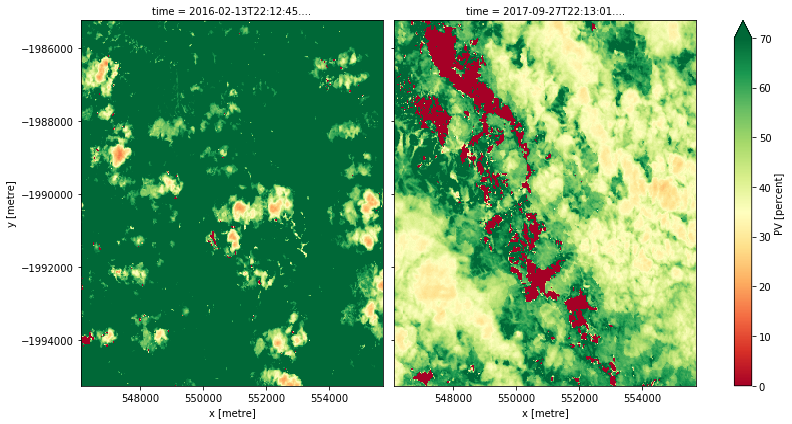

In [45]:
# Set the timesteps to visualise
initial_timestep = 5
final_timestep = 69

fc.PV.isel(time=[initial_timestep, final_timestep]).plot.imshow(
    'x', 'y', col='time', cmap='RdYlGn',  vmin=0, vmax=70, figsize=(12, 6))

plt.show()


## Perform hypothesis test
While it is possible to visually detect change between the two timesteps, it is important to consider how to rigorously check for both positive change in the PV (afforestation) and negative change in the PV (deforestation).

This can be done through hypothesis testing.
In this case, 

$$
\begin{aligned}
\text{null hypothesis } (H_0) &: \text{no change occurred,} \\
\text{alternative hypothesis } (H_1) &: \text{some change occurred.}
\end{aligned}
$$

The hypothesis test will indicate where there is evidence for rejecting the null hypothesis.
From this, we may identify areas of signficant change, according to a given significance level (covered in more detail below).

### Make samples

To perform the test, the total sample will be split in two: a `baseline` sample and a `postbaseline` sample, which respectively contain the data before and after the `time_baseline` date.
Then, we can test for a difference in the average PV % between the samples for each pixel in the sample.

The samples are made by selecting the `NDVI` band from the dataset and filtering it based on whether it was observed before or after the `time_baseline` date.
The number of observations in each sample will be printed.
If one sample is much larger than the other, consider changing the `time_baseline` parameter in the "Analysis parameters" cell, and then re-run this cell.
Coordinates are recorded for later use.

**Note**: This may take a couple of minutes to run because at this stage we fully compute the arrays we _lazily_ loaded using dask earlier.

In [40]:
# Make samples
baseline_sample = fc.PV.sel(time=fc['time'] <= np.datetime64(time_baseline))
baseline_sample = baseline_sample.compute()
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

postbaseline_sample = fc.PV.sel(time=fc['time'] > np.datetime64(time_baseline))
postbaseline_sample = postbaseline_sample.compute()
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

# Record coodrinates for reconstructing xarray objects
sample_lat_coords = fc.coords['y']
sample_lon_coords = fc.coords['x']


Number of observations in baseline sample: 28
Number of observations in postbaseline sample: 50


### Test for change
To look for evidence that the average PV % has changed between the two samples (either positively or negatively), we use Welch's t-test.
This is used to test the hypothesis that two populations have equal averages.
In this case, the populations are the area of interest before and after the `time_baseline` date, and the average being tested is the average PV %.
Welch's *t*-test is used (as opposed to Student's *t*-test) because the two samples in the study may not necessarily have equal variances. 

The test is run using the Scipy package's statistcs library, which provides the `ttest_ind` function for running *t*-tests. 
Setting `equal_var=False` means that the function will run Welch's *t*-test.
The function returns the *t*-statistic and *p*-value for each pixel after testing the difference in the average NDVI.
These are stored as `t_stat` and `p_val` inside the `t_test` dataset for use in the next section.

In [41]:
# Perform the t-test on the postbaseline and baseline samples
tstat, p_tstat = stats.ttest_ind(
    postbaseline_sample.values,
    baseline_sample.values,
    equal_var=False,
    nan_policy='omit',
)

# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {'t_stat': (['y', 'x'], tstat),
     'p_val': (['y', 'x'], p_tstat)},
    coords={
     'x': (['x'], sample_lon_coords.values),
     'y': (['y'], sample_lat_coords.values)
    }, attrs={'crs': 'EPSG:3577'})

print(t_test)


<xarray.Dataset>
Dimensions:  (x: 319, y: 334)
Coordinates:
  * x        (x) float64 5.462e+05 5.462e+05 5.462e+05 ... 5.557e+05 5.557e+05
  * y        (y) float64 -1.985e+06 -1.985e+06 ... -1.995e+06 -1.995e+06
Data variables:
    t_stat   (y, x) float64 -0.8794 -0.7862 -0.6711 ... -1.278 -1.332 -1.353
    p_val    (y, x) float64 0.383 0.4351 0.5049 0.4862 ... 0.207 0.1888 0.1822
Attributes:
    crs:      EPSG:3577


## Visualise change
From the test, we're interested in two conditions: whether the change is significant (rejection of the null hypothesis) and whether the change was positive (afforestation) or negative (deforestation).

The null hypothesis can be rejected if the $p$-value (`p_val`) is less than the chosen significance level, which is set as `sig_level = 0.05` for this analysis.
If the null hypothesis is rejected, the pixel will be classified as having undergone significant change.

The direction of the change can be inferred from the difference in the average PV % of each sample, which is calculated as $$\text{diff mean} = \text{mean(post baseline)} - \text{mean(baseline)}.$$
This means that
- if the average PV % for a given pixel is **higher** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **positive**.
- if the average PV % for a given pixel is **lower** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **negative**.

Run the cell below to first plot the difference in the mean between the two samples, then plot only the differences that were marked as signficant. 
**Positive change is shown in blue and negative change is shown in red.**

In [42]:
# Set the significance level
sig_level = 0.05

# Plot any difference in the mean
diff_mean = postbaseline_sample.mean(
    dim=['time']) - baseline_sample.mean(dim=['time'])

# Plot any difference in the mean classified as significant
sig_diff_mean = postbaseline_sample.mean(dim=['time']).where(
    t_test.p_val < sig_level) - baseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level)


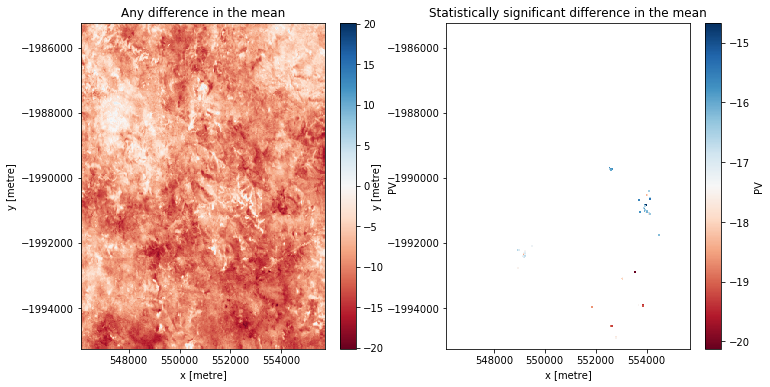

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
diff_mean.plot(cmap='RdBu', ax=ax[0])
sig_diff_mean.plot(cmap='RdBu', ax=ax[1])
ax[0].set_title('Any difference in the mean')
ax[1].set_title('Statistically significant difference in the mean')

plt.show()


## Drawing conclusions
Here are some questions to think about:
- What has happened in the forest over the time covered by the dataset?
- Were there any statistically significant changes that the test found that you didn't see in the true-colour images? 
- What kind of activities/events might explain the significant changes?
- What kind of activities/events might explain non-significant changes?
- What other information might you need to draw conclusions about the cause of the statistically significant changes?

## Export the data
To explore the data further in a desktop GIS program, the data can be output as a GeoTiff.
This requires data to be converted to an xarray and tagged with the appropriate coordinate reference system (`crs`). 
The `diff_mean` product will be saved as "ttest_diff_mean.tif", and the `sig_diff_mean` product will be saved as "ttest_sig_diff_mean.tif".
These files can be downloaded from the file explorer to the left of this window ([see these instructions](https://jupyterlab.readthedocs.io/en/stable/user/files.html#uploading-and-downloading)).

In [27]:
# Make datasets into xarrays for output
diff_mean_out = xr.Dataset({'diff_mean': diff_mean}, attrs={
                           'crs': CRS('EPSG:3577')})

sig_diff_mean_out = xr.Dataset({'sig_diff_mean': sig_diff_mean}, attrs={
                               'crs': CRS('EPSG:3577')})

# Write output to geotiffs
write_geotiff(filename="ttest_diff_mean.tif", dataset=diff_mean_out)
write_geotiff(filename="ttest_sig_diff_mean.tif", dataset=sig_diff_mean_out)


## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `time` or `time_baseline`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [15]:
print(datacube.__version__)

1.7+130.g81bed714.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)